<a href="https://colab.research.google.com/github/juampamuc/notebooks/blob/main/DiffeoMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Dependencies

### Libraries

In [ ]:
# Pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
! pip install torch
# Pytorch lightning
! pip install pytorch_lightning
import pytorch_lightning as pl
import torchmetrics
# Numpy/Scipy
import numpy as np
from scipy.ndimage import gaussian_filter
# For plotting:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
from IPython.display import clear_output
from time import sleep
# Install se2cnn from repository
! rm se2cnn -r -f
! git clone https://github.com/ebekkers/se2cnn.git
! mv ./se2cnn/se2cnn ./se2cnn2
! rm se2cnn -r -f
! mv se2cnn2 se2cnn
import se2cnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.6 MB/s eta 0:00:00
Cloning into 'se2cnn'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 50 (delta 14), reused 38 (delta 9), pack-reused 0
Receiving objects: 100% (50/50), 13.53 KiB | 4.51 MiB/s, done.
Resolving deltas: 100% (14/14), done.


### Some functions used in this notebook

#### Generating vector fields, using them to warp images, plot function

In [ ]:
# Function to generate a random smooth vector field
def generate_smooth_vector_field(batch_size, dim_i, dim_j, num_control_points=4, sigma=1.0):
    noise_i = torch.randn(batch_size, num_control_points, num_control_points) * sigma
    noise_j = torch.randn(batch_size, num_control_points, num_control_points) * sigma
    field_low_resolution = torch.stack((noise_i, noise_j), dim=1)  # [B, 2, X, Y]
    field = torch.nn.functional.upsample(field_low_resolution, (dim_i, dim_j), mode='bicubic')
    return field

# Function to apply diffeomorphic warp to an image using a vector field
def apply_diffeomorphic_warp(image, vector_field):
    batch_size, num_channels, dim_i, dim_j = image.shape
    # Construct index grid
    i, j = torch.meshgrid(torch.arange(dim_i), torch.arange(dim_j))
    grid_ij = torch.stack((i,j), dim=-1).unsqueeze(0)
    # Deform grid
    grid_ij = grid_ij + vector_field.permute(0,2,3,1)
    # Convert to image grid (normalize coords to -1,1), flip x and y
    image_grid = (grid_ij / (dim_j - 1) - 0.5) * 2.0
    image_grid = torch.stack([image_grid[...,1], image_grid[...,0]], dim=-1)
    # Apply transformation f_warped(x) = f_original(x + vec), so vec points in
    # the direction where the original pixel came from
    warped_image = F.grid_sample(image, image_grid.type_as(image), align_corners=False)#.transpose(1,2)
    return warped_image

# A function to visualize the deformation field (scalar field + vector field)
def plot_s_v(s,v):
    step = 1  # plot every other pixel
    r, c = s.shape
    Y, X = np.mgrid[0:r:step,0:c:step]
    dY, dX = v[0,0:r:step,0:c:step], v[1,0:c:step,0:c:step]
    plt.imshow(s.squeeze().numpy(), cmap='gray')
    plt.quiver(X, Y, dX, dY, color='r', scale=1, units='xy', angles='xy')

#### For rotating scalar and vector fields

In [ ]:
def rotate_scalar_field_90(s):
    return s.transpose(1,2).flip(1)

def rotate_vector_field_90(v):
    # Rotate domain
    v_90 = v.transpose(2,3).flip(2)
    # And codomain
    v_90 = v_90.flip(1)
    v_90[:,0,:,:] = v_90[:,0,:,:] * -1.
    return v_90

# PROBLEM 1: Given an image plus vector field apply the diffeomorphic deformation

We consider the problem of deforming a scalar image $f^{s}:\mathbb{R}^2 \rightarrow \mathbb{R}$ using a vector field $v:\mathbb{R}^2 \rightarrow \mathbb{R}^2$ via
$$ f^{t}(x)=f^s(x+v(x)) \, .$$
For discrete data this essentially boils down to an interpolation problem, i.e., if we want to fill in the pixels of the output (target) image $f^t(x)$, at pixel locations $x$, we merely need to look up what the pixel values $f^s(x+v(x))$ were in the source image at pixel locations $x+v(x)$. This is in fact how we will construct the training dataset of triplets $(f^s, v, f^t)$, using the above defined functions ```generate_smooth_vector_field``` to generate random deformations and ```apply_diffeomorphic_warp``` to generate $f^t$ from $f^s$ and $v$.

In the second part of this notebook we consider the more challenging problem of predicting the vector field $v$ from the source and target images $f^s$ and $f^t$, which is essentially is a registration problem.

### Download MNIST

In [ ]:
# Load MNIST dataset
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.RandomRotation(180)])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# In order to not make the notebook too computationally demanding we take a subset (5%) of the entire MNIST datset
mnist_dataset, _ = torch.utils.data.random_split(mnist_dataset, [round(len(mnist_dataset)*0.05),round(len(mnist_dataset)*0.95)])

100%|██████████| 9912422/9912422 [00:00<00:00, 207639770.49it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 112475110.33it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 80236343.56it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18495659.00it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Constructing the DiffeoMNIST dataset

Here we loop over the entire dataset (in batches) and randomly deform each input sample.

In [ ]:
# Create a new dataset with original and warped images along with vector fields
num_control_points=5  # per axis, so we put ncpxncp random vectors and interpolate the remaining vectors in between
sigma=2.0  # each random vector is sampled from a Gaussian with this std
# Data loader
batch_size = 1000
dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)
# Loop over the data and apply the transformations
original_images = []
vector_fields = []
warped_images = []
for image, label in dataloader:
    # Apply random deformation to batch
    batch_size, num_channels, height, width = image.shape
    vector_field = generate_smooth_vector_field(batch_size, height, width, num_control_points=num_control_points,sigma=sigma)
    warped_image = apply_diffeomorphic_warp(image, vector_field)
    # Add result to list
    original_images.append(image)
    vector_fields.append(vector_field)
    warped_images.append(warped_image)
    # break
# Collect all batches in one big tensor
original_images = torch.cat(original_images,dim=0)
vector_fields = torch.cat(vector_fields,dim=0)
warped_images = torch.cat(warped_images,dim=0)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Let's visualize the result for a number of samples. Left is the source image. Right is the target image, with as overlay the vector field $v$. The red arrows point towards the pixels where their values came from (from the source image though). Conversely, one can think of this vector field as a flow, which if you let the target image flow along it you would generate the source image back.

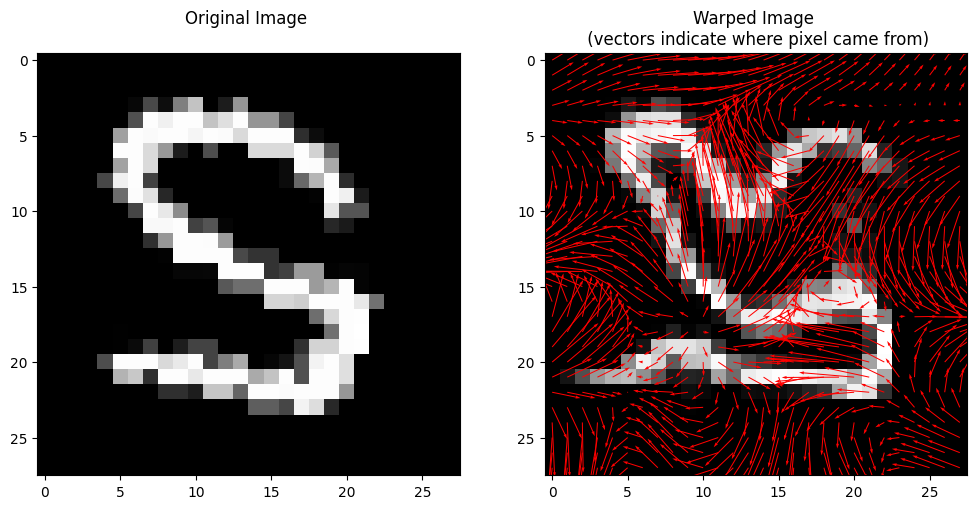

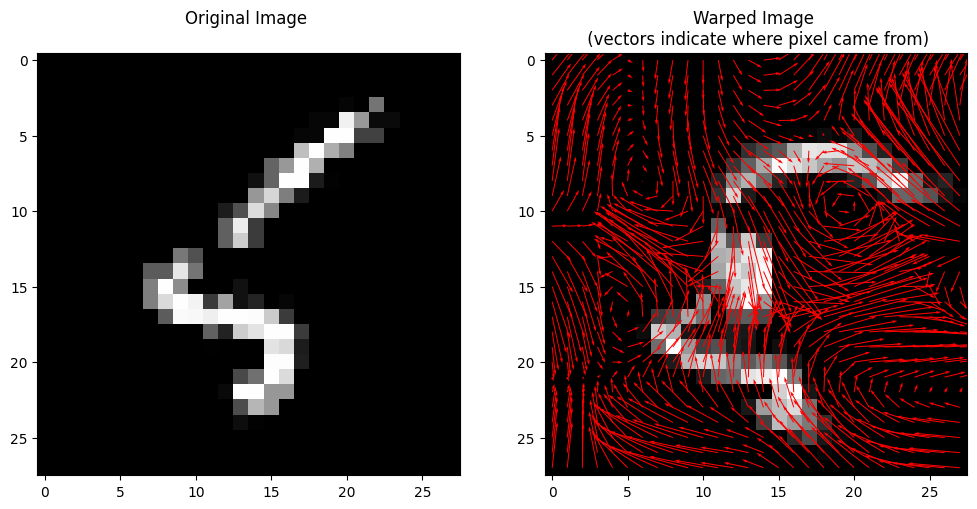

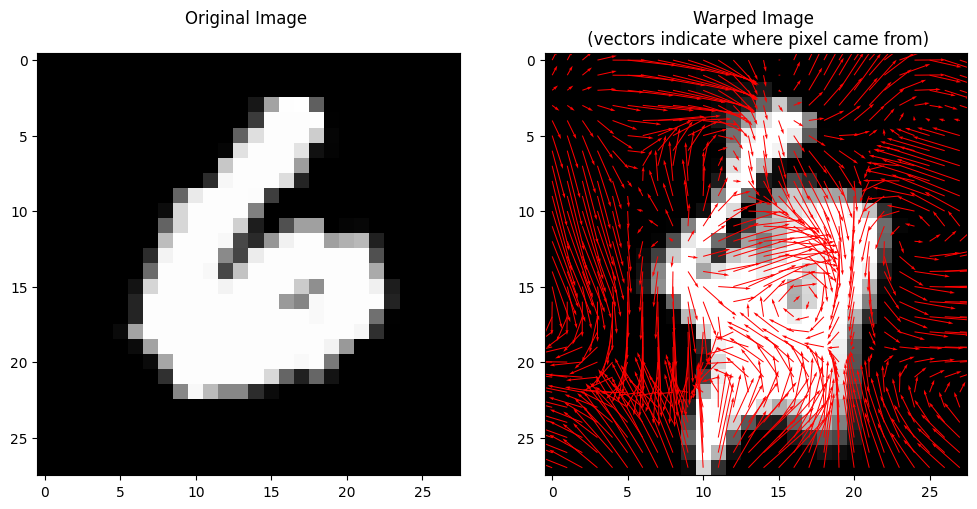

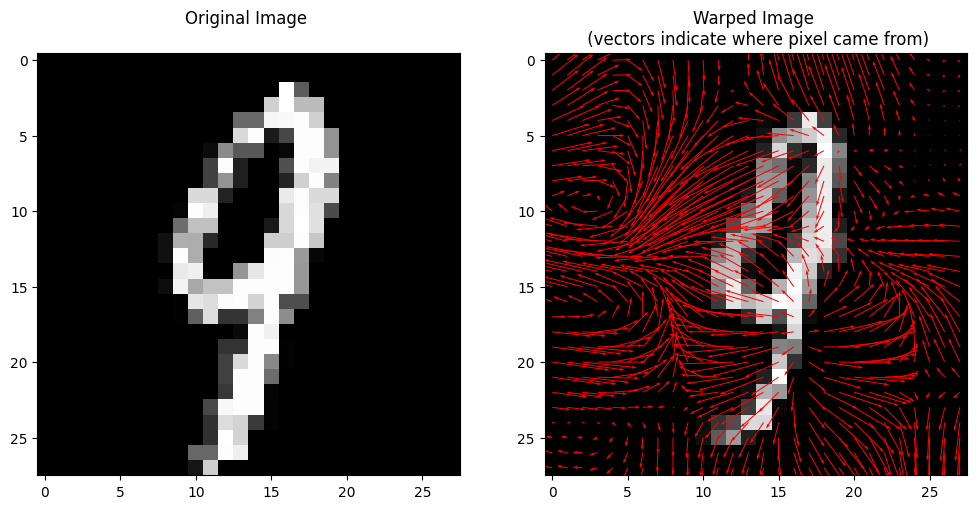

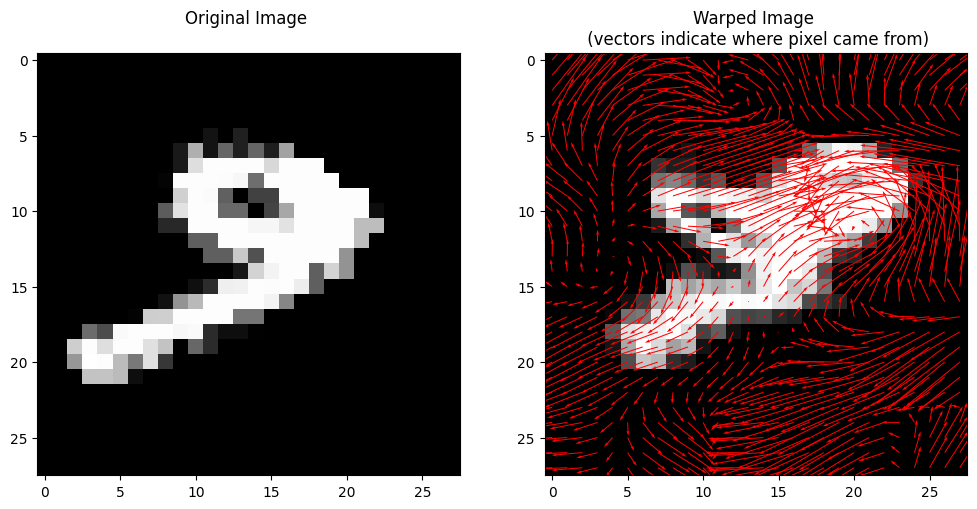

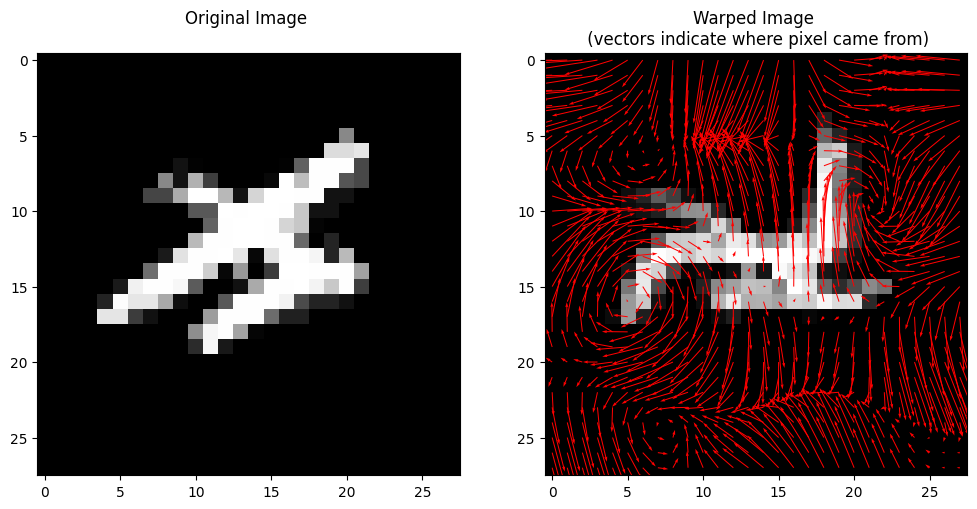

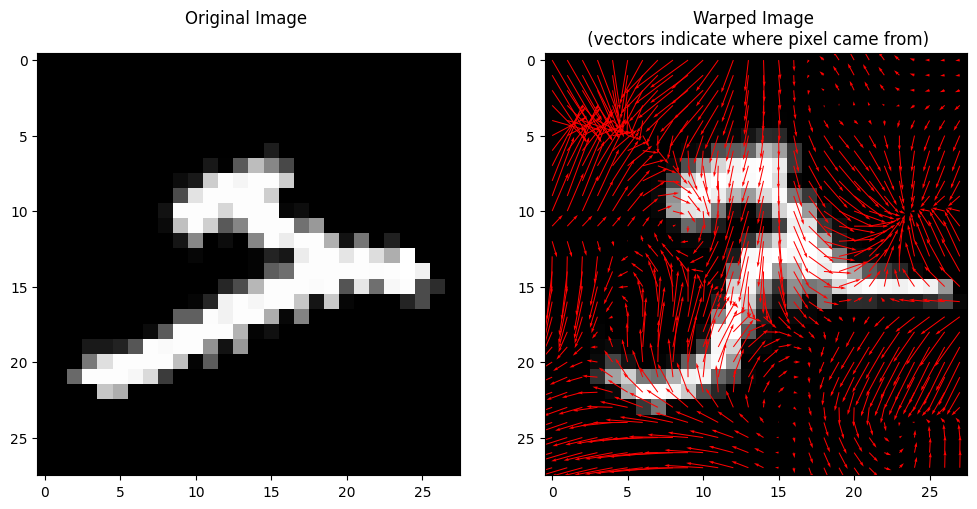

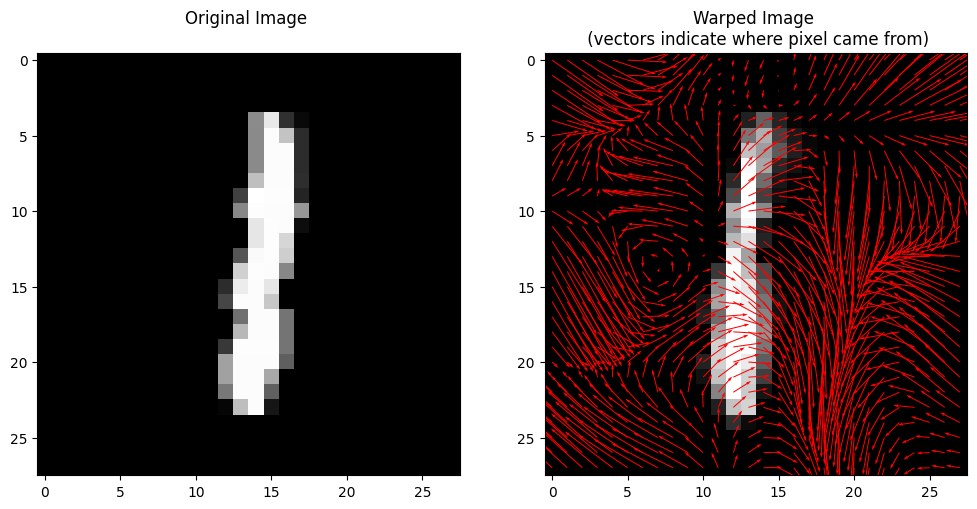

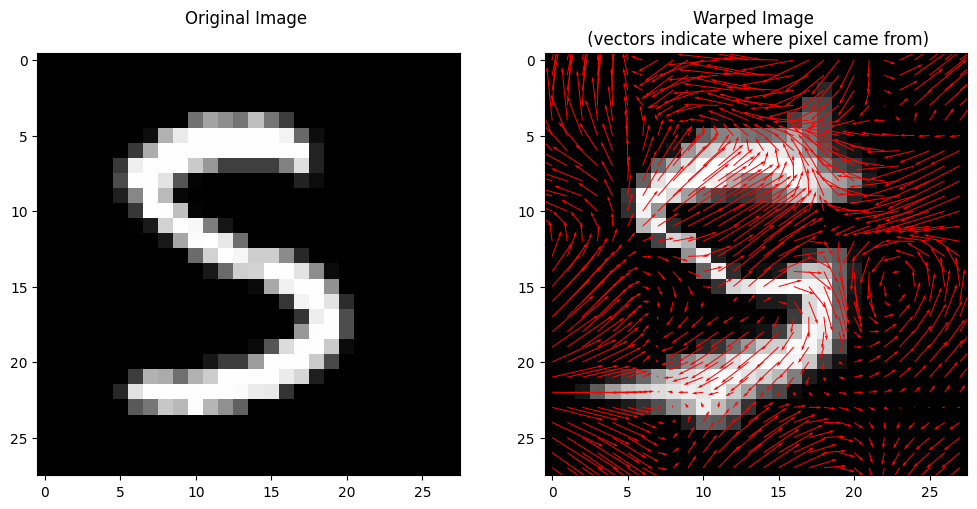

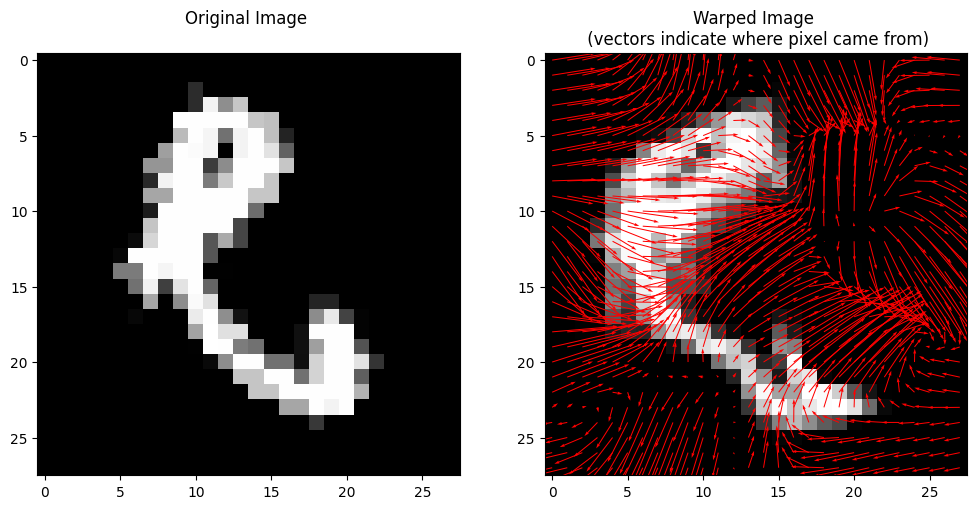

In [ ]:
num_to_show=10
for imnr in range(num_to_show):
    # Select the image
    original_image = original_images[imnr,0]
    vector_field = vector_fields[imnr]
    warped_image = warped_images[imnr,0]

    # Plot the original
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(original_image.numpy(), cmap='gray')
    plt.title('Original Image \n')
    # Plot the warped together with vector field
    plt.subplot(122)
    plot_s_v(warped_image, vector_field)
    plt.title('Warped Image \n (vectors indicate where pixel came from)')
    plt.show()
    # sleep(1)
    # clear_output(wait=True)

### Constructing the actual training data

It is our objective to simulate this interpolation. As inputs we take the original image + the vector field, the output should be the warped image. The dimensions of the training data are as follows:

In [ ]:
print(original_images.shape, vector_fields.shape, warped_images.shape)

torch.Size([3000, 1, 28, 28]) torch.Size([3000, 2, 28, 28]) torch.Size([3000, 1, 28, 28])


Here we concatenate the source scalar field with the vector field, create a torch ```Dataset``` out of it, and generate random train/val/test splits.

In [ ]:
# Define inputs and target (labels)
inputs = torch.cat((original_images,vector_fields), dim=1)
targets = warped_images
diffeo_mnist_dataset = torch.utils.data.TensorDataset(inputs,targets)
# Split the data into train, validation and test
size = len(diffeo_mnist_dataset)
split_sizes = [round(size*0.8), round(size*0.1), round(size*0.1)]
diffeo_mnist_train, diffeo_mnist_val, diffeo_mnist_test = torch.utils.data.random_split(diffeo_mnist_dataset, split_sizes)

## Equivariant architectures

The problem requires equivariance. Let us simply denote the representation of $SE(2)$ with group elements $g=(t,R) \in SE(2)$ acting on both scalar and vector fields as $g . f$ and $g . v$. Scalar fields $f$ are acted upon via
$$[g . f](x) = f(g^{-1} x) = f(R^{-1}(x - t)) \, .$$
Vector fields $v$ transforms via the induced representation of $SE(2)$ via
$$[g . v](x) = R.v(R^{-1}.(x-t)) \, ,$$
i.e., the domain rotates and translates but also the codomain (vectors) rotate. The neural network that should perform the mapping $f^t = NN(f^s,v]$ should be equivariant via
$$g . f^t = NN(g . f^s, g . v] \, .$$
This means that **we have to use group convolutions**.


A couple of cells below we will verify whether or neural networks satisfy this equivariance constraint via implementation so the SE(2) representation, via our above defined functions ```rotate_scalar_field_90``` and ```rotate_vector_field_90``` which are however only defined for 90degree rotations (sorry had limited time to write this notebook!).

Let us first construct both an equivariant group convolutional method, and a standard CNN which is only translation equivariant.

### Equivariant group convolutional model

We build the network via the implementation of [Roto-translation covariant convolutional networks for medical image analysis](https://arxiv.org/abs/1804.03393), Bekkers and Lafarge et al, MICCAI 2018. The repository ```se2cnn``` can be found [here](https://github.com/ebekkers/se2cnn). We construct our network via the simple recipe
1. Lift scalar and vector fields to functions on $SE(2)$ via the module ```Fourier.irrep_to_regular```, which is essentialy an inverse $SO(2)$ Fourier transform. I.e., in this step $f(x,R)=F^{-1}[f(x)](R)$ in which the scalar at $f(x)$ represents the 0-frequency and thus the inverse Fourier transform will give a constant signal $f(x,R)=f(x)$ over $R$. The vectors $v(x)$ are treated as frequency one Fourier coeffients, leading to a cosine wave $f(x,R)=F^{-1}[v(x)](R)$ of frequency 1 with a phase and magnitude give by $v$.

2. Perform regular group convolutions with feature maps $f:SE(2)\rightarrow\mathbb{R}^C$. We here do this using a ConvNeXt type convolution block as implemented in ```SE2ToSE2ConvNext```.

3. Convert the output signal over $SE(2)$ back to either a scalar field or vector field via a Fourier transform, filtering out either the 0-frequency or 1-frequency component for scalars and vectors respectively. We do this via ```Fourier.regular_to_irrep```.

In [ ]:
from se2cnn.nn import Fourier, SE2ToSE2Conv, SE2ToSE2ConvNext
class GConvNet(nn.Module):
    def __init__(self,
                 input_dim_s,
                 input_dim_v,
                 hidden_dim,
                 output_dim_s,
                 output_dim_v,
                 num_layers,
                 kernel_size,
                 n=8):
        super().__init__()

        # Input output settings
        self.input_dim_s, self.input_dim_v = input_dim_s, input_dim_v
        self.output_dim_s, self.output_dim_v = output_dim_s, output_dim_v
        self.num_layers = num_layers

        # The Fourier tansformation module
        self.fourier_trafo = Fourier(n)

        # Activation function to use internally
        self.act_fn = torch.nn.GELU()

        # Initial node embedding such that what ever remains uses hidden_dim
        # self.read_in_layer = SE2ToSE2Conv(input_dim_s + input_dim_v, hidden_dim, n, 1, 0)
        self.read_in_layer = nn.Linear(input_dim_s + input_dim_v, hidden_dim)

        # Make feedforward network
        self.conv_layers = nn.ModuleList()
        for i in range(num_layers):
            self.conv_layers.append(SE2ToSE2ConvNext(hidden_dim, hidden_dim, n, kernel_size, padding=kernel_size//2))

        # read out layer
        self.read_out_layer = nn.Sequential(self.act_fn,
                                            nn.Linear(hidden_dim,hidden_dim),
                                            self.act_fn,
                                            nn.Linear(hidden_dim, output_dim_s + output_dim_v))

    def forward(self, input_scalar_field, input_vector_field):

        # Concatenate the regular fiber representations of scalar and vec field
        x = []
        if input_scalar_field is not None:
            # Technical inconvenience, the Fourier components are always treated
            # in cos/sin pairs, even for frequency 1, hence this line:
            inp = torch.cat([input_scalar_field[:,:,None,:,:]]*2,dim=2)
            x.append(self.fourier_trafo.irrep_to_regular(inp, 0))
        if input_vector_field is not None:
            x.append(self.fourier_trafo.irrep_to_regular(input_vector_field, 1))
        x = torch.cat(x,dim=1)  # [B, S+V, Num_orientations, X, Y]

        # Read-in layer (map to hidden_dim)
        x = self.read_in_layer(x.permute(0,2,3,4,1)).permute(0,4,1,2,3)

        # Convolution layers
        for layer in self.conv_layers:
            x = layer(x)

        # Read-out layer (map to output dim)
        output = self.read_out_layer(x.permute(0,2,3,4,1)).permute(0,4,1,2,3)  #[B, numout, O, X, Y]

        # Convert to scalar and vector field
        if self.output_dim_s > 0:
            output_s = self.fourier_trafo.regular_to_irrep(output[:,:self.output_dim_s],0)
            output_s = output_s[:,:,0,...]  # again, because 0-frequency components is stored in the first position of the cos/sin tuple
        else:
            output_s = None
        if self.output_dim_v > 0:
            output_v = self.fourier_trafo.regular_to_irrep(output[:,self.output_dim_s:],1)
        else:
            output_v = None

        # Return scalar and vector prediction
        return output_s, output_v

### The non-rotationally equivariant Conv2D baseline

We use the same ```SE2ToSE2ConvNext``` block as in the G-CNN, but with a discretization of $SO(2)$ with only 1 element, which essentially means only translations (no rotations) and thus a Conv2D block.

In [ ]:
# from torch.nn import Conv2d
class R2ConvNet(nn.Module):
    def __init__(self,
                 input_dim_s,
                 input_dim_v,
                 hidden_dim,
                 output_dim_s,
                 output_dim_v,
                 num_layers,
                 kernel_size):
        super().__init__()

        # Input output settings
        self.input_dim_s, self.input_dim_v = input_dim_s, input_dim_v
        self.output_dim_s, self.output_dim_v = output_dim_s, output_dim_v
        self.num_layers = num_layers

        # Activation function to use internally
        self.act_fn = torch.nn.GELU()

        # Initial node embedding
        self.read_in_layer = nn.Linear(input_dim_s + input_dim_v * 2, hidden_dim)

        # Make feedforward network
        self.conv_layers = nn.ModuleList()
        for i in range(num_layers):
            self.conv_layers.append(SE2ToSE2ConvNext(hidden_dim, hidden_dim, 1, kernel_size, padding=kernel_size//2))

        # read out layer
        self.read_out_layer = nn.Sequential(self.act_fn,
                                            nn.Linear(hidden_dim,hidden_dim),
                                            self.act_fn,
                                            nn.Linear(hidden_dim, output_dim_s + output_dim_v * 2))

    def forward(self, input_scalar_field, input_vector_field):

        # Concatenate the regular fiber representations of scalar and vec field
        x = []
        if input_scalar_field is not None:
            x.append(input_scalar_field)  # scalar_field.shape = [B,1,X,Y]
        if input_vector_field is not None:
            x.append(input_vector_field.flatten(1,2))  # input_vector_field.shape = [B,1,3,X,Y], we now treat the 3 componts of the vector as 3 channels
        x = torch.cat(x,dim=1)

        # Read-in layer
        x = self.read_in_layer(x.permute(0,2,3,1)).permute(0,3,1,2)

        # Convolution layers
        for layer in self.conv_layers:
            x = layer(x[:,:,None])[:,:,0]

        # Read-out layer
        output = self.read_out_layer(x.permute(0,2,3,1)).permute(0,3,1,2)

        # Convert to scalar and vector field
        if self.output_dim_s > 0:
            output_s = output[:,:self.output_dim_s]
        else:
            output_s = None
        if self.output_dim_v > 0:
            output_v = output[:,self.output_dim_s:].unflatten(1, (self.output_dim_v, -1))
        else:
            output_v = None

        # Return scalar and vector prediction
        return output_s, output_v

### Showing that the G-CNN is equivariant, and the CNN is not

Let's construct the models

In [ ]:
model_gcnn = GConvNet(input_dim_s=1,
                 input_dim_v=1,
                 hidden_dim=128,
                 output_dim_s=1,
                 output_dim_v=0,
                 num_layers=5,
                 kernel_size=5,
                 n=8)
model_cnn = R2ConvNet(input_dim_s=1,
                 input_dim_v=1,
                 hidden_dim=128,
                 output_dim_s=1,
                 output_dim_v=0,
                 num_layers=5,
                 kernel_size=5)

We pick one data point and make rotated copies of it. We both transform the scalar and the vector field:

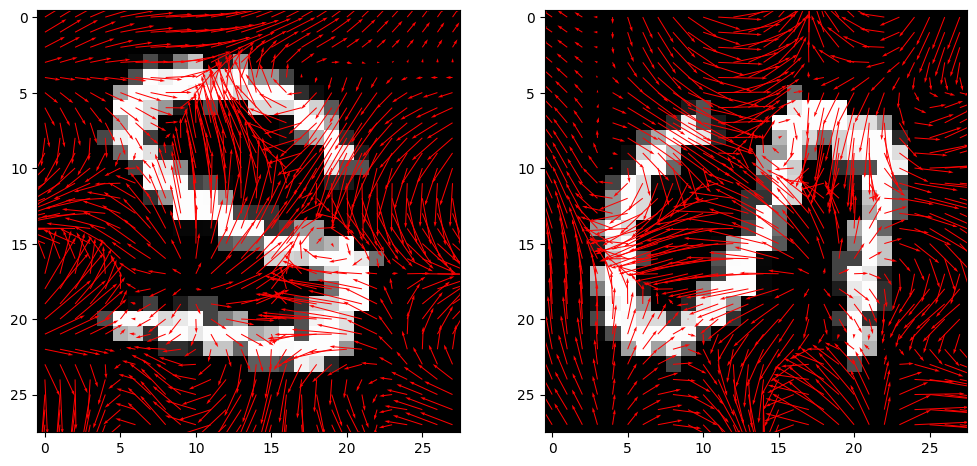

In [ ]:
# Pick a data point
one_s = inputs[0, :1]  # [1, X, Y]
one_v = inputs[0, None, 1:]  # [1, 2, X, Y]
# Rotate scalar field
one_s_90 = rotate_scalar_field_90(one_s)
# Rotate vector field (domain)
one_v_90 = rotate_vector_field_90(one_v)
# Show result
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_s_v(one_s[0], one_v[0])
plt.subplot(122)
plot_s_v(one_s_90[0], one_v_90[0])
plt.show()

We then pull both the original and rotated inputs through the neural networks and compare the results.

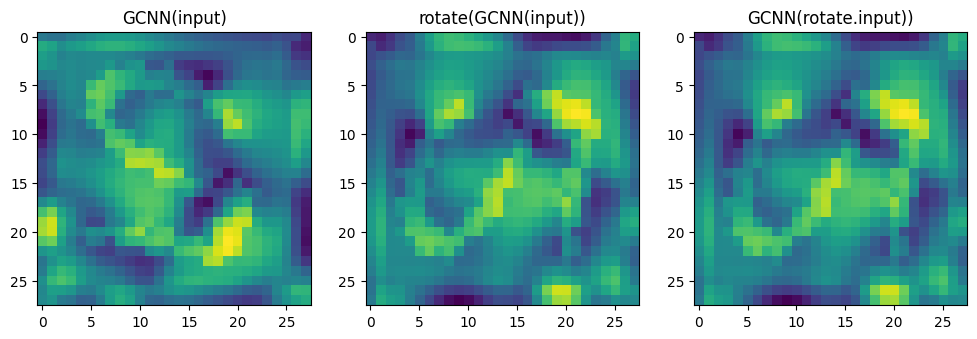

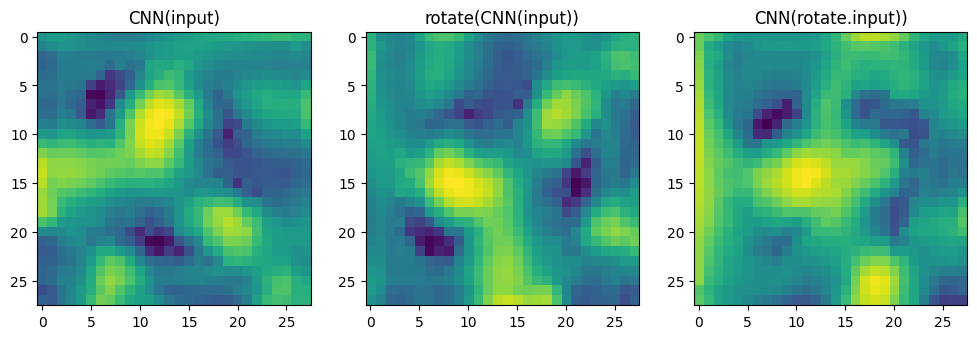

In [ ]:
# Compute output from unrotated inputs
out_gcnn, _ = model_gcnn(one_s[None], one_v[None])
out_cnn, _ = model_cnn(one_s[None], one_v[None])
# Compute output from rotated inputs
out_90_gcnn, _ = model_gcnn(one_s_90[None], one_v_90[None])
out_90_cnn, _ = model_cnn(one_s_90[None], one_v_90[None])
# Rotate the output of the unrotated input
out_gcnn_90 = rotate_scalar_field_90(out_gcnn[0])
out_cnn_90 = rotate_scalar_field_90(out_cnn[0])
# Show result of the gcnn
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(out_gcnn.squeeze().detach().numpy())
plt.title('GCNN(input)')
plt.subplot(132)
plt.imshow(out_gcnn_90.squeeze().detach().numpy())
plt.title('rotate(GCNN(input))')
plt.subplot(133)
plt.imshow(out_90_gcnn.squeeze().detach().numpy())
plt.title('GCNN(rotate.input))')
plt.show()
# Show result of the cnn
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(out_cnn.squeeze().detach().numpy())
plt.title('CNN(input)')
plt.subplot(132)
plt.imshow(out_cnn_90.squeeze().detach().numpy())
plt.title('rotate(CNN(input))')
plt.subplot(133)
plt.imshow(out_90_cnn.squeeze().detach().numpy())
plt.title('CNN(rotate.input))')
plt.show()

## So the G-CNN -but not the CNN- is equivariant! Let's use it to solve Problem 1

### Pytorch Lightning Wrapper for easy experimentation

Pytorch Lightning takes care of optimizers, train, validation, test steps and what not...

In [ ]:
class DiffeoMNIST(pl.LightningModule):
    def __init__(self, model, lr=5e-4, weight_decay=1e-10):
        super().__init__()

        # Store some of the relevant args
        self.lr = lr
        self.weight_decay = weight_decay

        # The metrics to log
        self.train_metric = torchmetrics.MeanSquaredError()
        self.valid_metric = torchmetrics.MeanSquaredError()
        self.test_metric = torchmetrics.MeanSquaredError()

        # Make the model
        self.input_dim_s = 1
        self.input_dim_v = 1
        self.model = model

    def input_to_scalar_and_vector_field(self, inputs):
        input_s = inputs[:,:self.input_dim_s]
        input_v = inputs[:,self.input_dim_s:].unflatten(1, (self.input_dim_v,-1))
        return input_s, input_v

    def forward(self, batch):
        inputs, targets = batch
        input_s, input_v = self.input_to_scalar_and_vector_field(inputs[None])
        output_s, output_v = self.model(input_s, input_v)
        return output_s

    def training_step(self, batch):
        inputs, targets = batch
        input_s, input_v = self.input_to_scalar_and_vector_field(inputs)
        output_s, output_v = self.model(input_s, input_v)
        loss = torch.mean((output_s - targets)**2)
        self.train_metric(output_s, targets)
        return loss

    def on_training_epoch_end(self):
        self.log("train MSE", self.train_metric, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        input_s, input_v = self.input_to_scalar_and_vector_field(inputs)
        output_s, output_v = self.model(input_s, input_v)
        self.valid_metric(output_s, targets)

    def on_validation_epoch_end(self):
        self.log("valid MSE", self.valid_metric, prog_bar=True)

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        input_s, input_v = self.input_to_scalar_and_vector_field(inputs)
        output_s, output_v = self.model(input_s, input_v)
        self.test_metric(output_s, targets)

    def on_test_epoch_end(self):
        self.log("test MSE", self.test_metric)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return {"optimizer": optimizer, "monitor": "val_loss"}

### The data loaders

In [ ]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(diffeo_mnist_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(diffeo_mnist_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(diffeo_mnist_test, batch_size=batch_size, shuffle=False)

### Define the training settings (train ```model_gcnn``` and ```model_cnn```)

In [ ]:
# Network settings
# hidden_dim_cnn = 42  # Gets more channels to ensure cnn and gcnn have
# hidden_dim_gcnn = 32 # approximately equal number of weights
hidden_dim_cnn = 24  # Gets more channels to ensure cnn and gcnn have
hidden_dim_gcnn = 16 # approximately equal number of weights
num_layers = 3
kernel_size = 5
n=8
# Training settings
epochs = 20
lr = 5e-4
# Construct the models
model_gcnn = GConvNet(input_dim_s=1, input_dim_v=1, hidden_dim=hidden_dim_gcnn, output_dim_s=1, output_dim_v=0, num_layers=num_layers, kernel_size=kernel_size, n=n)
model_cnn = R2ConvNet(input_dim_s=1, input_dim_v=1, hidden_dim=hidden_dim_cnn, output_dim_s=1, output_dim_v=0, num_layers=num_layers, kernel_size=kernel_size)
# And the lightning wrappers
model_gcnn_pl = DiffeoMNIST(model=model_gcnn, lr=lr)
model_cnn_pl = DiffeoMNIST(model=model_cnn, lr=lr)
# Initialize the trainer
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
trainer_cnn = pl.Trainer(max_epochs=epochs, accelerator=accelerator)
trainer_gcnn = pl.Trainer(max_epochs=epochs, accelerator=accelerator)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Training of the CNN

In [ ]:
# Training of the cnn
trainer_cnn.fit(model_cnn_pl, train_loader, val_loader)
trainer_cnn.test(model_cnn_pl, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | train_metric | MeanSquaredError | 0     
1 | valid_metric | MeanSquaredError | 0     
2 | test_metric  | MeanSquaredError | 0     
3 | model        | R2ConvNet        | 16.9 K
--------------------------------------------------
16.9 K    Trainable params
0         Non-trainable params
16.9 K    Total params
0.068     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test MSE          │   0.010035226121544838    │
└───────────────────────────┴───────────────────────────┘

[{'test MSE': 0.010035226121544838}]

### Training of the G-CNN

In [ ]:
# Training of the gcnn
trainer_gcnn.fit(model_gcnn_pl, train_loader, val_loader)
trainer_gcnn.test(model_gcnn_pl, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | train_metric | MeanSquaredError | 0     
1 | valid_metric | MeanSquaredError | 0     
2 | test_metric  | MeanSquaredError | 0     
3 | model        | GConvNet         | 16.5 K
--------------------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test MSE          │   0.009293756447732449    │
└───────────────────────────┴───────────────────────────┘

[{'test MSE': 0.009293756447732449}]

### So the G-CNNs give slightly better results quantitatively, what does this qualitatively look like?

Here we plot the predicted outputs of the diffeomorphism as parametrized by inputs $f^s$ and $v$.

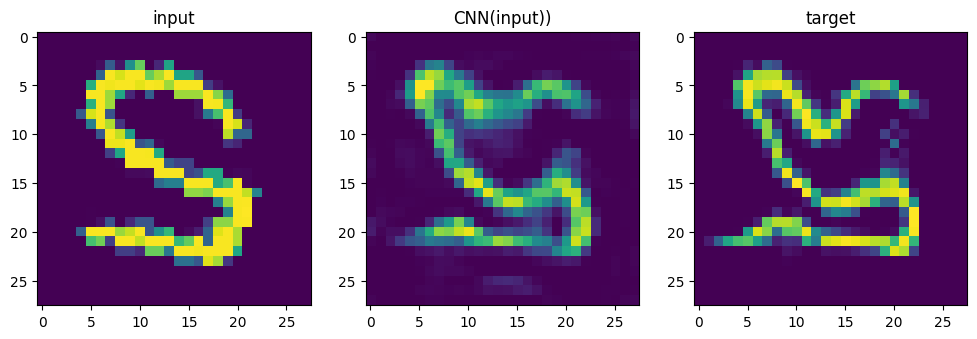

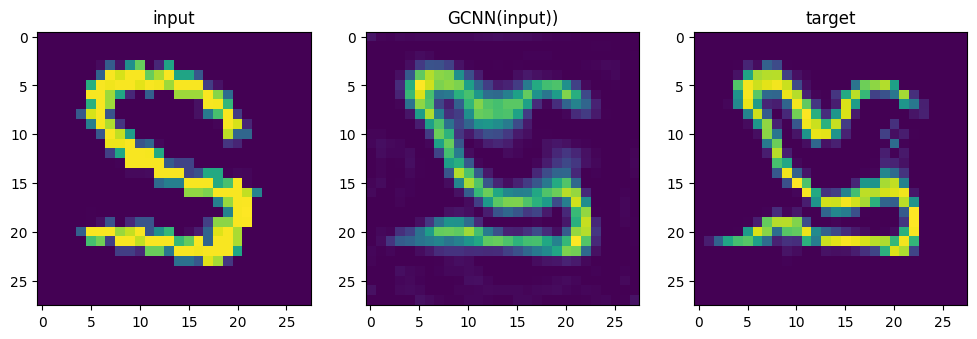

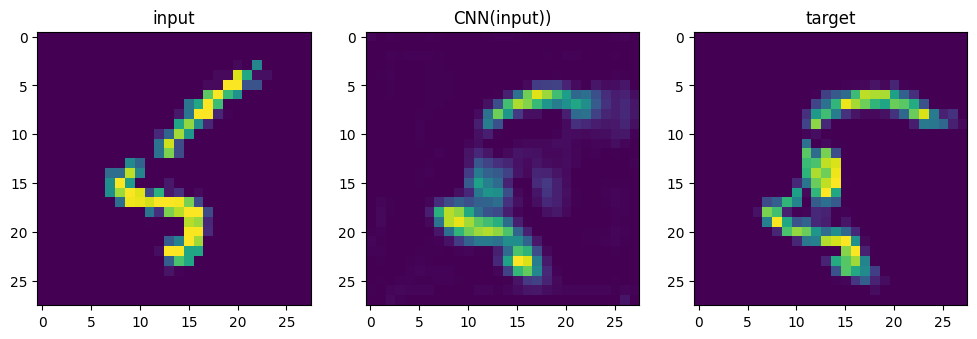

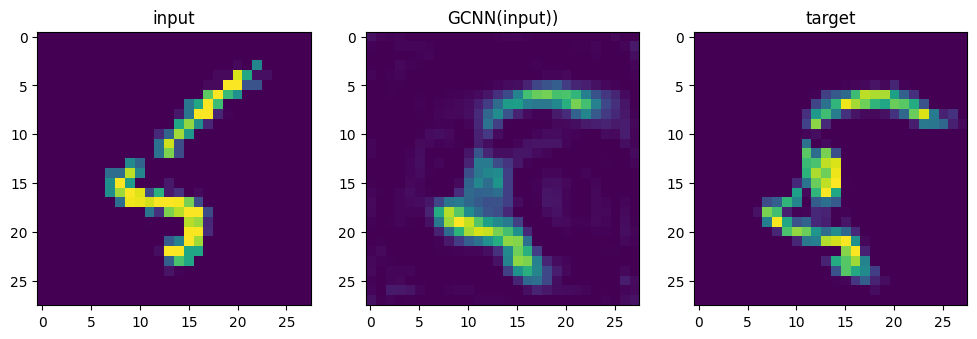

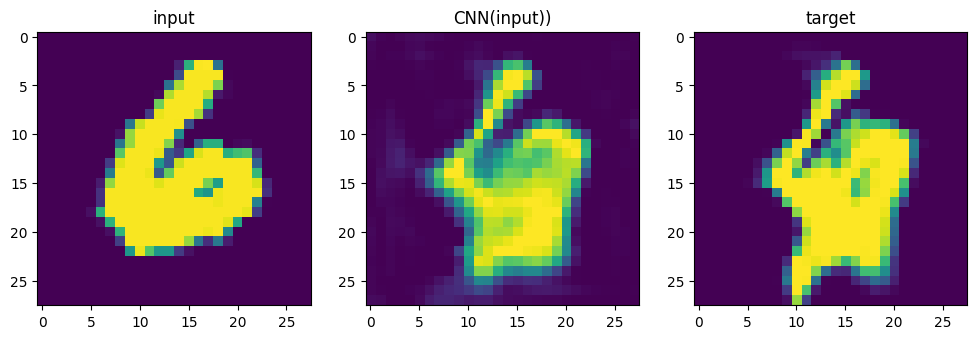

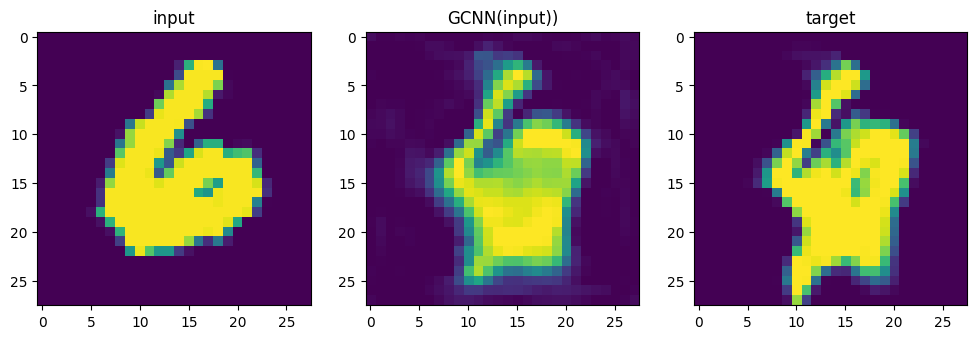

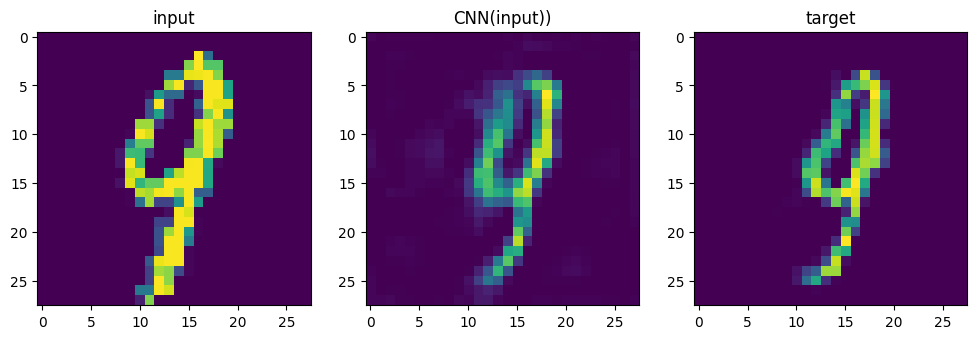

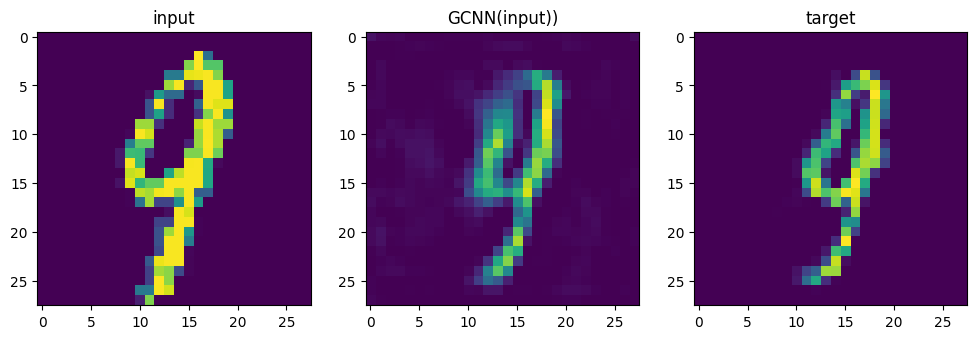

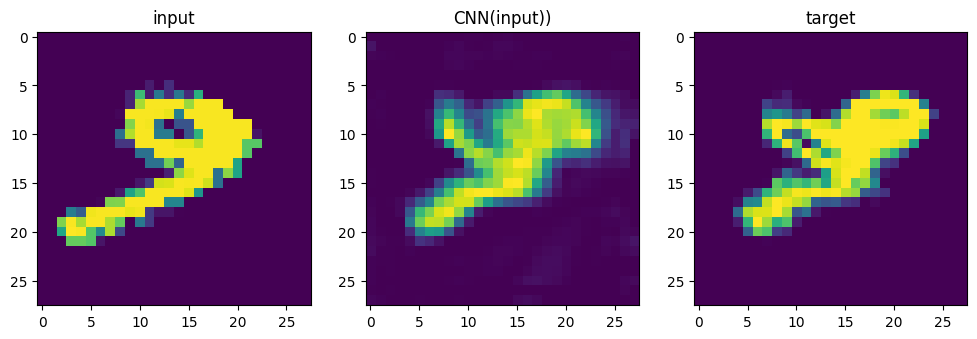

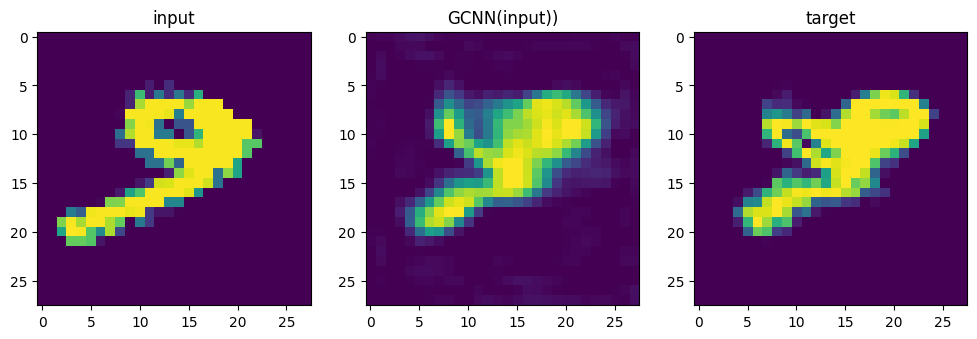

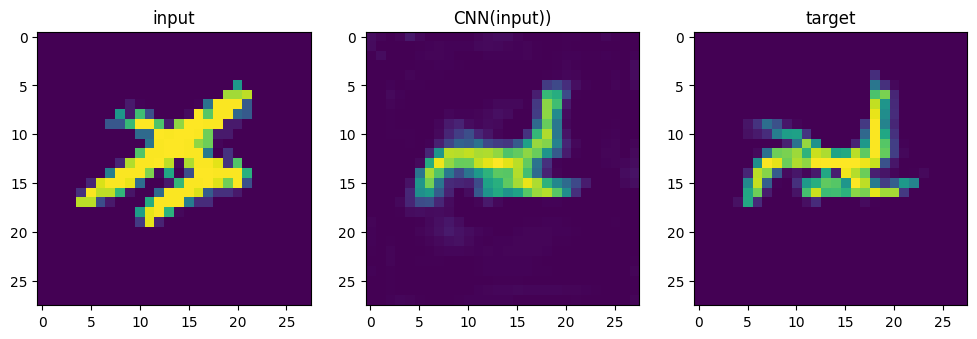

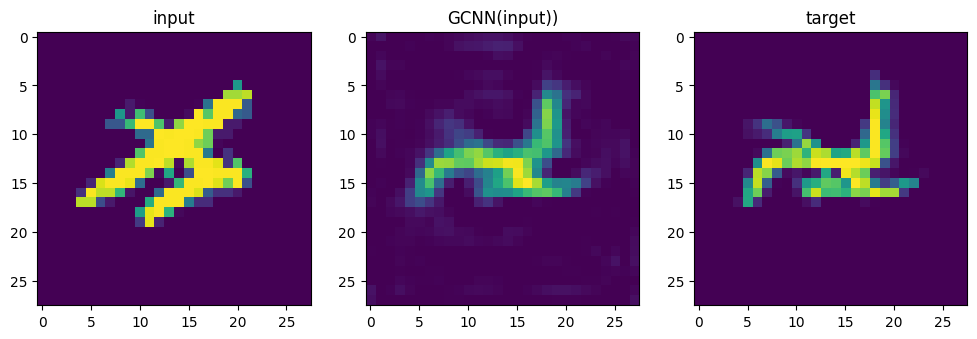

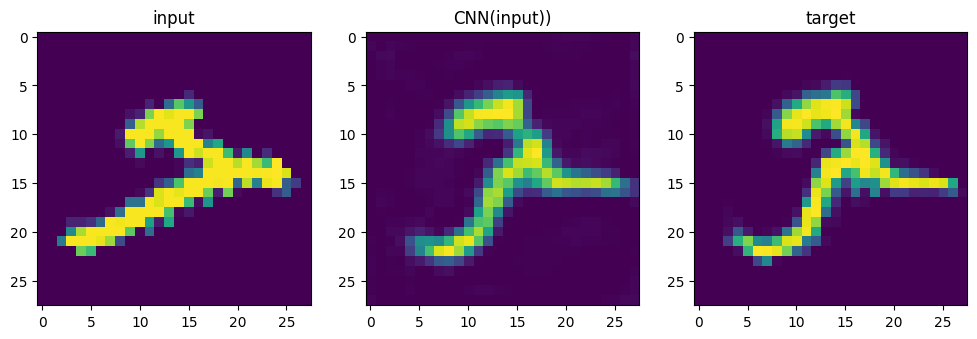

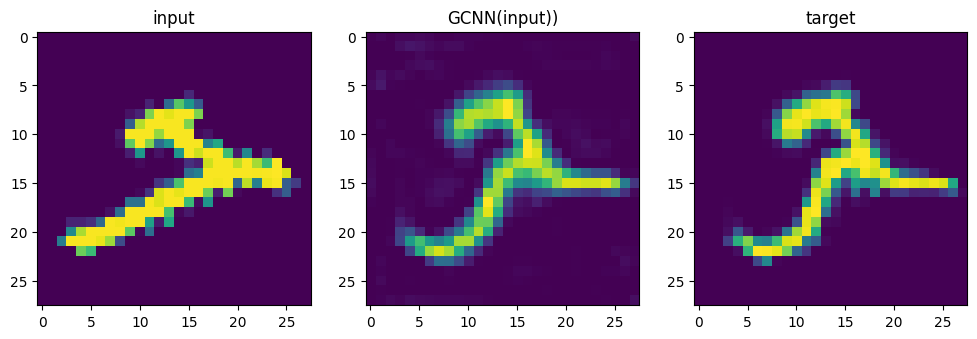

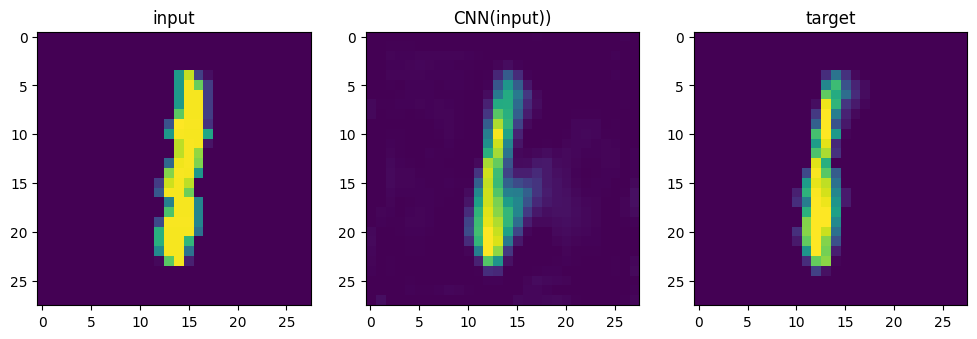

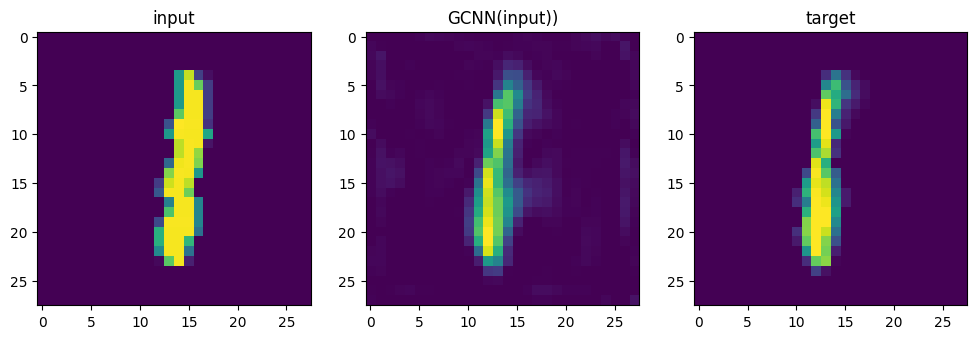

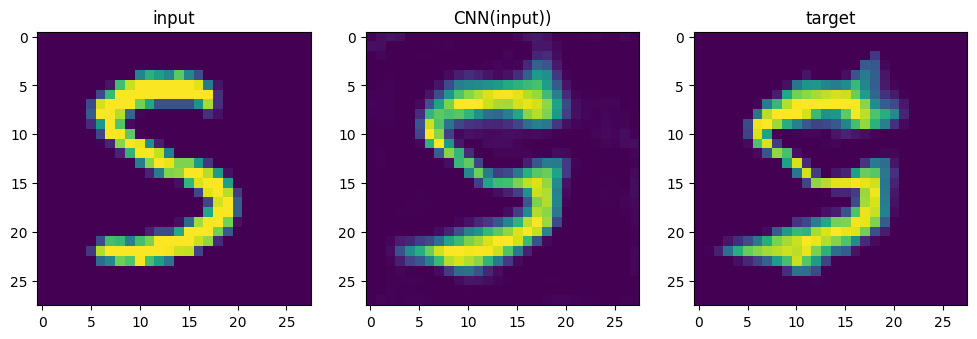

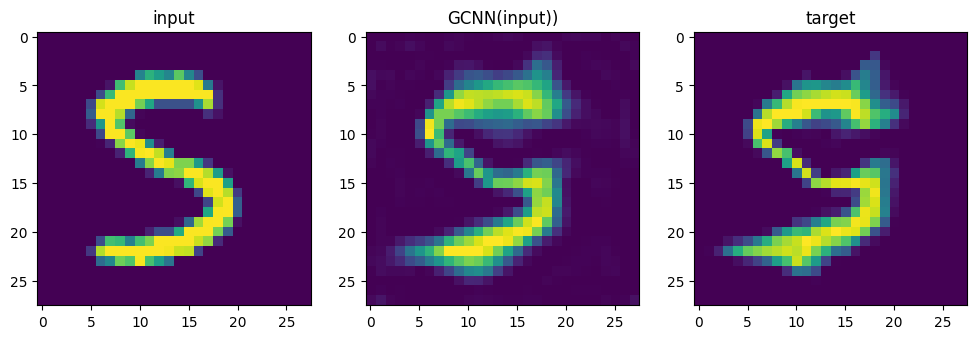

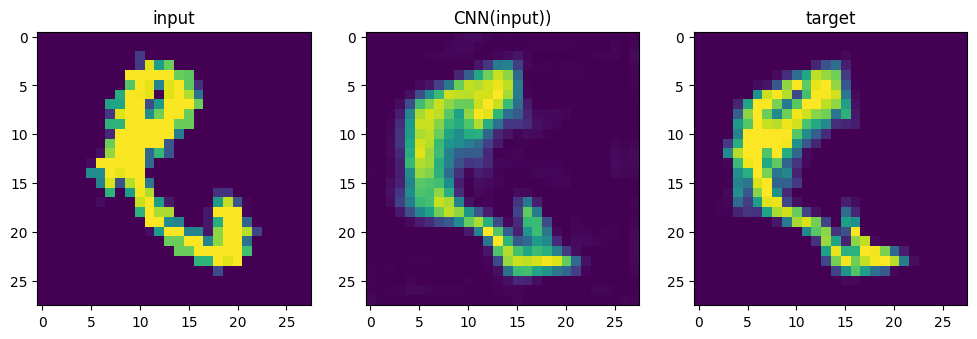

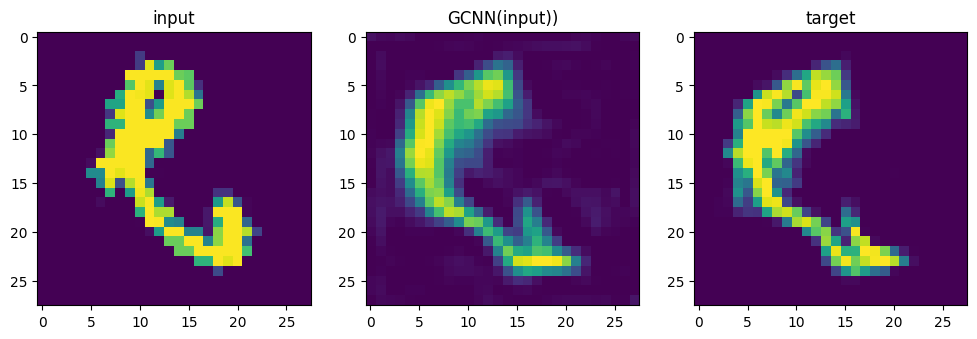

In [ ]:
# Make the plots for a number of images:
num_ims = 10
input_s = inputs[:num_ims,:1,:,:]
input_v = inputs[:num_ims,None,1:,:,:]
target = targets[:num_ims]
# Compute the warped images via the neural networks
out_cnn, _ = model_cnn_pl.model(input_s, input_v)
out_gcnn, _ = model_gcnn_pl.model(input_s, input_v)
# Show the results
for imnr in range(num_ims):
    # Show result (CNN)
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    plt.imshow(input_s[imnr].squeeze().numpy())
    plt.title('input')
    plt.subplot(132)
    plt.imshow(out_cnn[imnr].squeeze().clamp(0,1).detach().numpy())
    plt.title('CNN(input))')
    plt.subplot(133)
    plt.imshow(target[imnr].squeeze().numpy())
    plt.title('target')
    plt.show()
    # Show result (GCNN)
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    plt.imshow(input_s[imnr].squeeze().numpy())
    plt.title('input')
    plt.subplot(132)
    plt.imshow(out_gcnn[imnr].squeeze().clamp(0,1).detach().numpy())
    plt.title('GCNN(input))')
    plt.subplot(133)
    plt.imshow(target[imnr].squeeze().numpy())
    plt.title('target')
    plt.show()

# PROBLEM 2: Given a source and target image, what is the vector field that warps one onto the other?

We are now interested in finding the vector field $v$ such that $f^t(x) = f^s(x + v(x))$. We will train a neural network that esimates
$$v = NN(f^s,f^t) \, ,$$
using a training set of $(input,target)$ tuples $((f^s,f^t), v)$. These training samples are constructed as follows.

In [ ]:
# Define inputs and target (labels)
inputs = torch.cat((original_images,warped_images), dim=1)
targets = vector_fields
inv_diffeo_mnist_dataset = torch.utils.data.TensorDataset(inputs,targets)
# Split the data into train, validation and test
size = len(inv_diffeo_mnist_dataset)
split_sizes = [round(size*0.8), round(size*0.1), round(size*0.1)]
inv_diffeo_mnist_train, inv_diffeo_mnist_val, inv_diffeo_mnist_test = torch.utils.data.random_split(inv_diffeo_mnist_dataset, split_sizes)

In [ ]:
batch_size = 100
inv_train_loader = torch.utils.data.DataLoader(inv_diffeo_mnist_train, batch_size=batch_size, shuffle=True)
inv_val_loader = torch.utils.data.DataLoader(inv_diffeo_mnist_val, batch_size=batch_size, shuffle=False)
inv_test_loader = torch.utils.data.DataLoader(inv_diffeo_mnist_test, batch_size=batch_size, shuffle=False)

In [ ]:
class InvDiffeoMNIST(pl.LightningModule):
    def __init__(self, model, lr=5e-4, weight_decay=1e-10):
        super().__init__()

        # Store some of the relevant args
        self.lr = lr
        self.weight_decay = weight_decay

        # The metrics to log
        self.train_metric = torchmetrics.MeanSquaredError()
        self.valid_metric = torchmetrics.MeanSquaredError()
        self.test_metric = torchmetrics.MeanSquaredError()

        # Make the model
        self.input_dim_s = 2
        self.input_dim_v = 0
        self.model = model

    def input_to_scalar_and_vector_field(self, inputs):
        input_s = inputs[:,:self.input_dim_s]
        # input_v = inputs[:,self.input_dim_s:].unflatten(1, (self.input_dim_v,-1))
        input_v = None
        return input_s, input_v

    def forward(self, batch):
        inputs, targets = batch
        input_s, input_v = self.input_to_scalar_and_vector_field(inputs[None])
        output_s, output_v = self.model(input_s, input_v)
        return output_v

    def training_step(self, batch):
        inputs, targets = batch
        input_s, input_v = self.input_to_scalar_and_vector_field(inputs)
        output_s, output_v = self.model(input_s, input_v)
        loss = torch.mean((output_v.reshape(-1) - targets.reshape(-1))**2)
        self.train_metric(output_v.reshape(-1), targets.reshape(-1))
        return loss

    def on_training_epoch_end(self):
        self.log("train MSE", self.train_metric, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        input_s, input_v = self.input_to_scalar_and_vector_field(inputs)
        output_s, output_v = self.model(input_s, input_v)
        self.valid_metric(output_v.reshape(-1), targets.reshape(-1))

    def on_validation_epoch_end(self):
        self.log("valid MSE", self.valid_metric, prog_bar=True)

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        input_s, input_v = self.input_to_scalar_and_vector_field(inputs)
        output_s, output_v = self.model(input_s, input_v)
        self.test_metric(output_v.reshape(-1), targets.reshape(-1))

    def on_test_epoch_end(self):
        self.log("test MSE", self.test_metric)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return {"optimizer": optimizer, "monitor": "val_loss"}

In [ ]:
# Network settings
hidden_dim_cnn = 24
hidden_dim_gcnn = 16
num_layers = 3
kernel_size = 5
n=8
# Training settings
epochs = 20
lr = 5e-4
# Construct the models
inv_model_gcnn = GConvNet(input_dim_s=2, input_dim_v=0, hidden_dim=hidden_dim_gcnn, output_dim_s=0, output_dim_v=1, num_layers=num_layers, kernel_size=kernel_size, n=n)
inv_model_cnn = R2ConvNet(input_dim_s=2, input_dim_v=0, hidden_dim=hidden_dim_cnn, output_dim_s=0, output_dim_v=1, num_layers=num_layers, kernel_size=kernel_size)
# And the lightning wrappers
inv_model_gcnn_pl = InvDiffeoMNIST(model=inv_model_gcnn, lr=lr)
inv_model_cnn_pl = InvDiffeoMNIST(model=inv_model_cnn, lr=lr)
# Initialize the trainer
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
inv_trainer_cnn = pl.Trainer(max_epochs=epochs, accelerator=accelerator)
inv_trainer_gcnn = pl.Trainer(max_epochs=epochs, accelerator=accelerator)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Training of the cnn
inv_trainer_cnn.fit(inv_model_cnn_pl, inv_train_loader, inv_val_loader)
inv_trainer_cnn.test(inv_model_cnn_pl, inv_test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | train_metric | MeanSquaredError | 0     
1 | valid_metric | MeanSquaredError | 0     
2 | test_metric  | MeanSquaredError | 0     
3 | model        | R2ConvNet        | 16.9 K
--------------------------------------------------
16.9 K    Trainable params
0         Non-trainable params
16.9 K    Total params
0.068     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test MSE          │     2.389392852783203     │
└───────────────────────────┴───────────────────────────┘

[{'test MSE': 2.389392852783203}]

In [ ]:
# Training of the cnn
inv_trainer_gcnn.fit(inv_model_gcnn_pl, inv_train_loader, inv_val_loader)
inv_trainer_gcnn.test(inv_model_gcnn_pl, inv_test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | train_metric | MeanSquaredError | 0     
1 | valid_metric | MeanSquaredError | 0     
2 | test_metric  | MeanSquaredError | 0     
3 | model        | GConvNet         | 16.5 K
--------------------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test MSE          │    2.1930835247039795     │
└───────────────────────────┴───────────────────────────┘

[{'test MSE': 2.1930835247039795}]

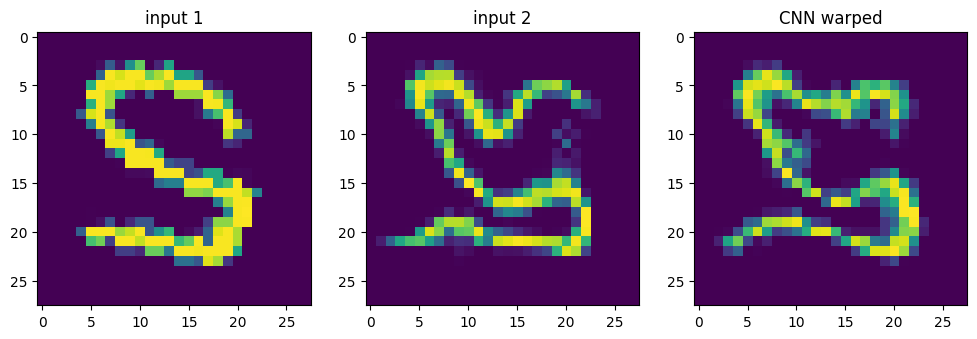

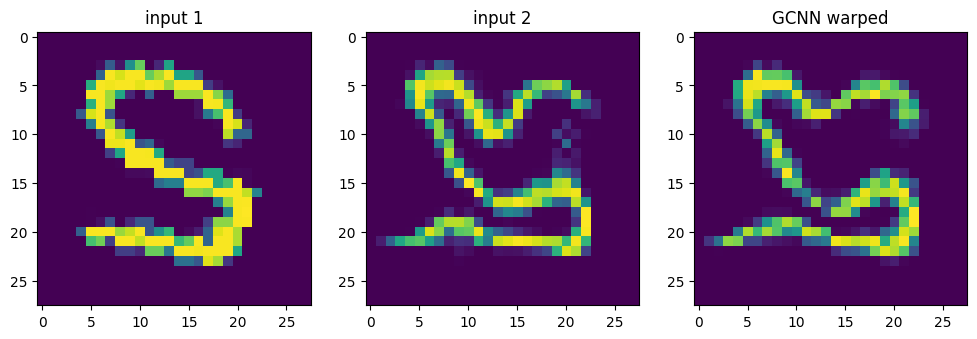

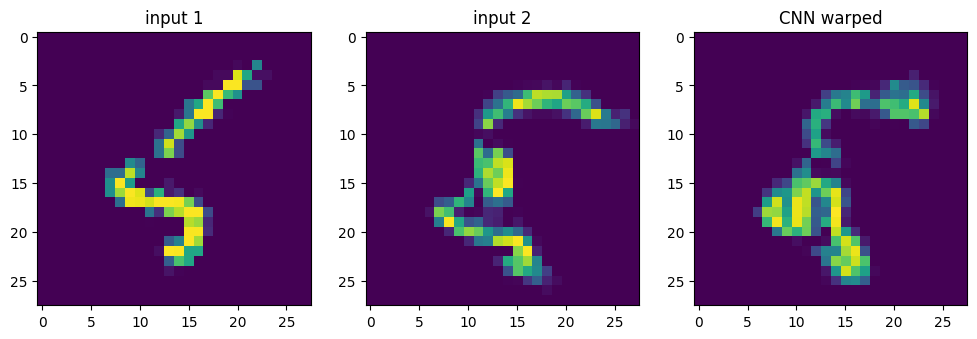

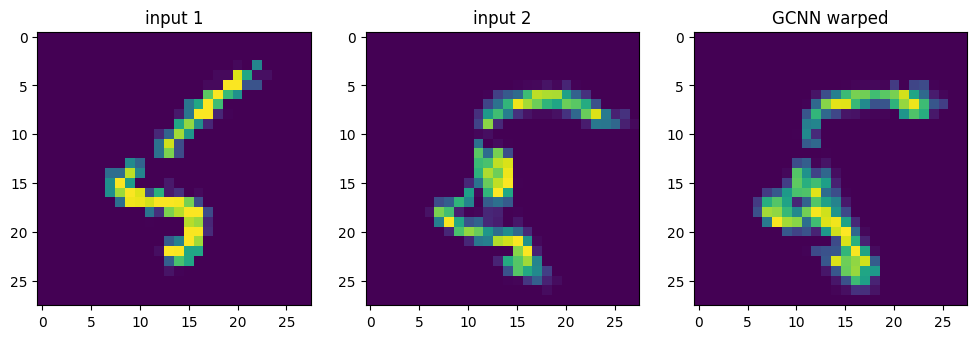

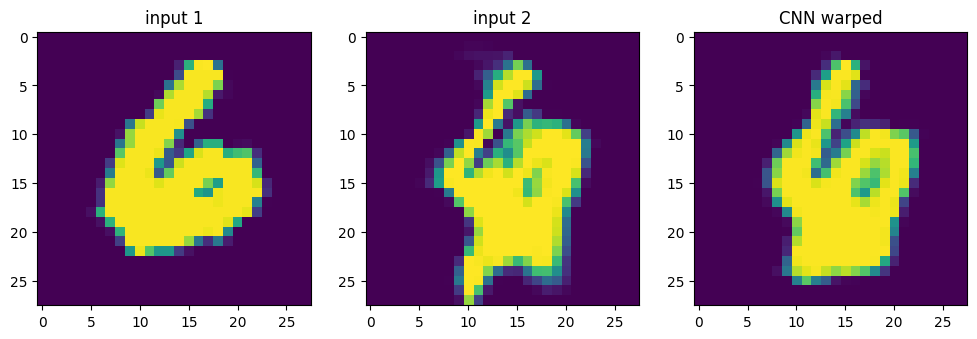

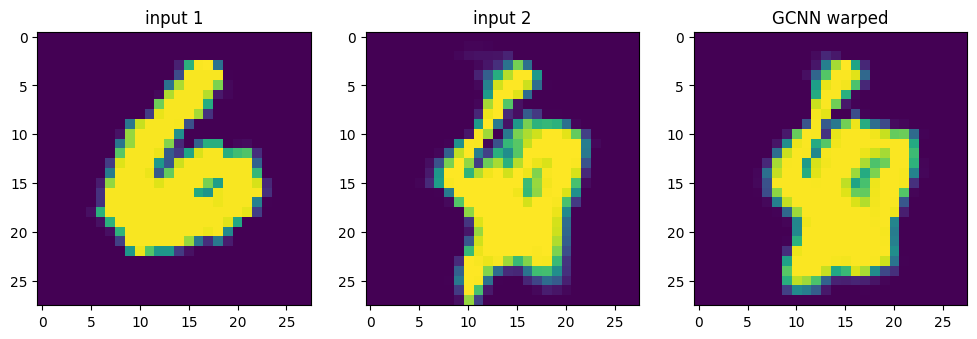

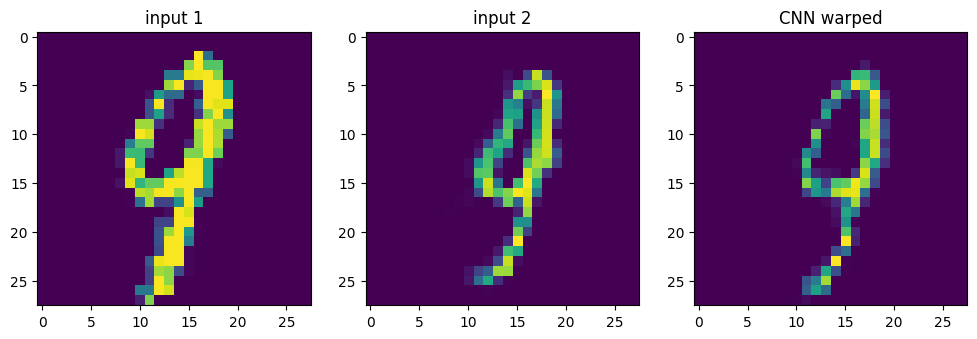

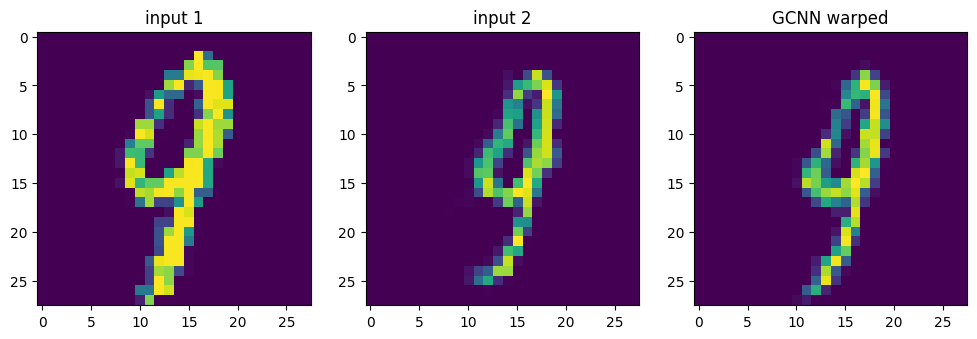

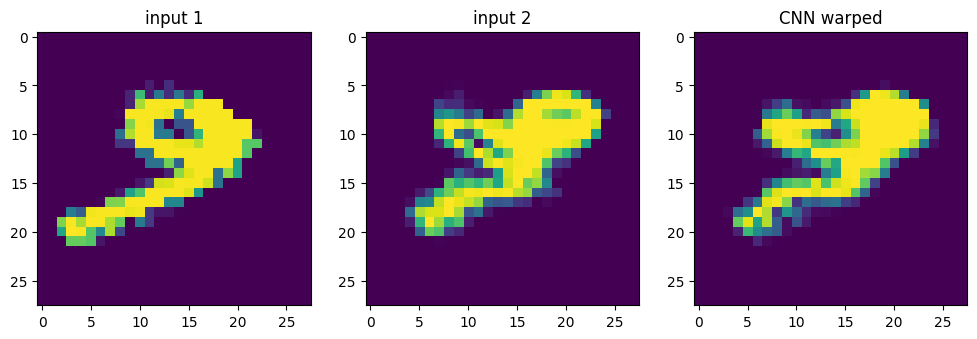

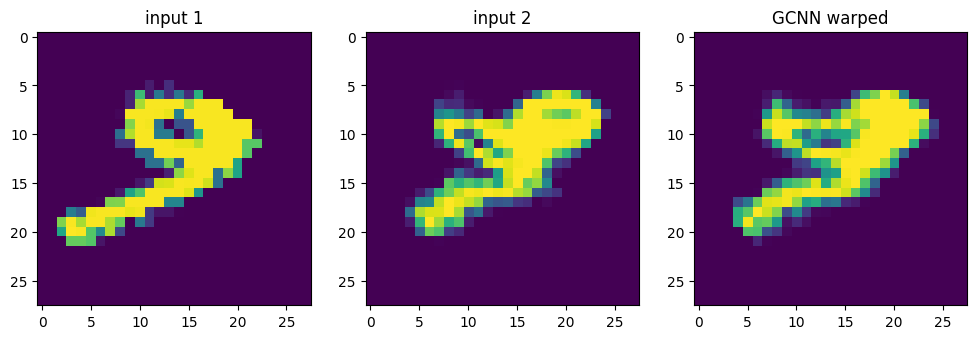

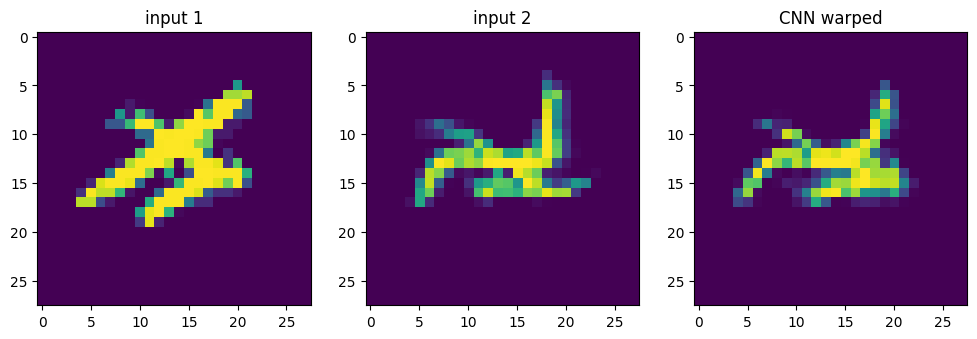

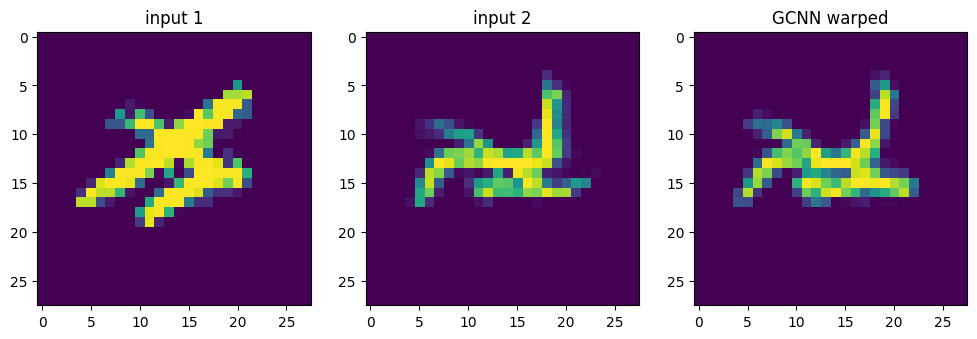

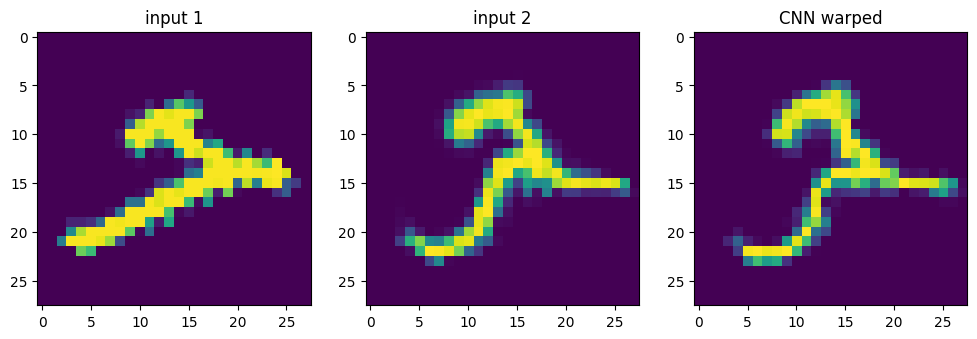

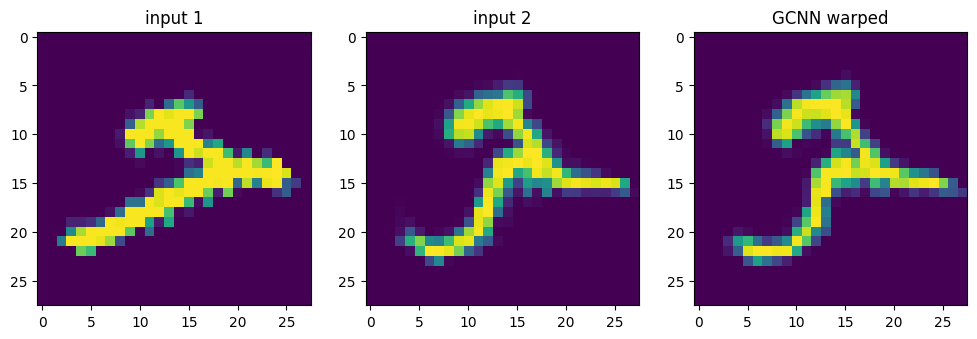

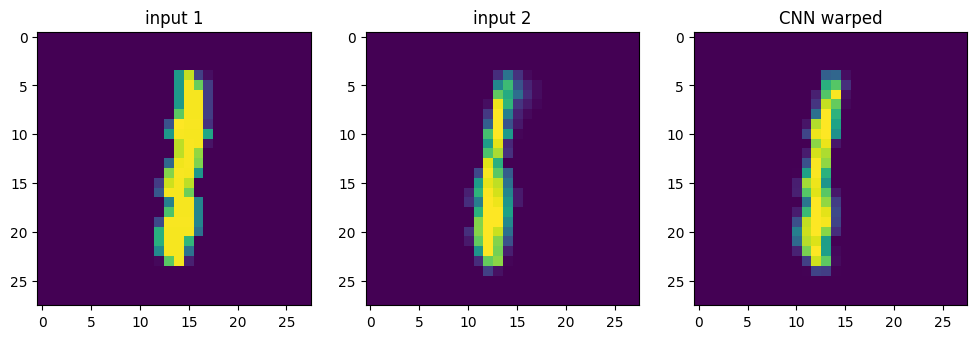

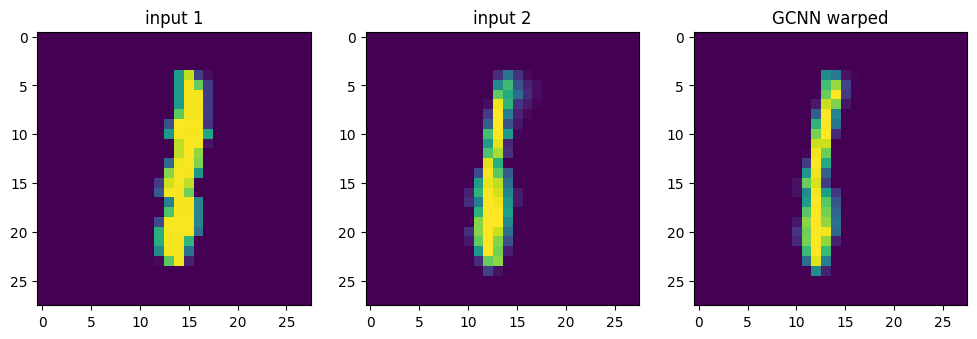

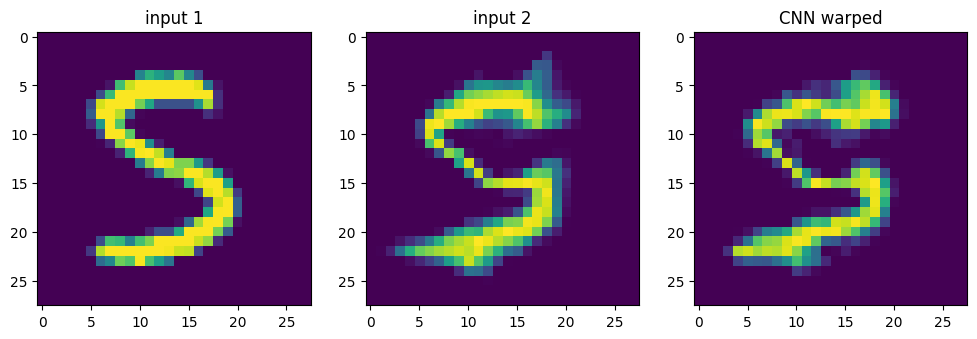

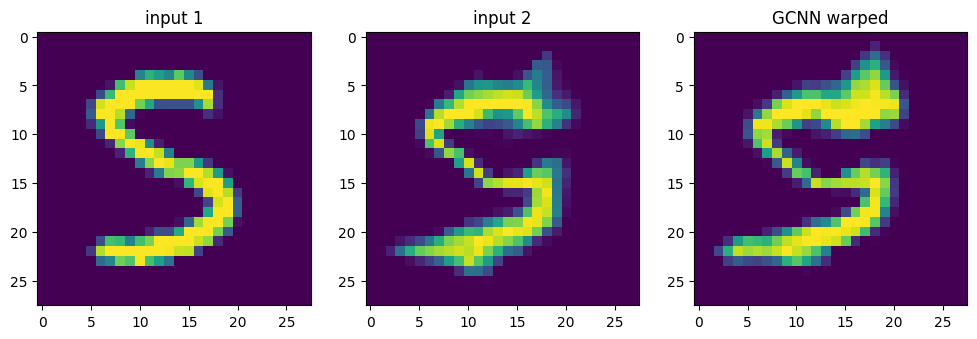

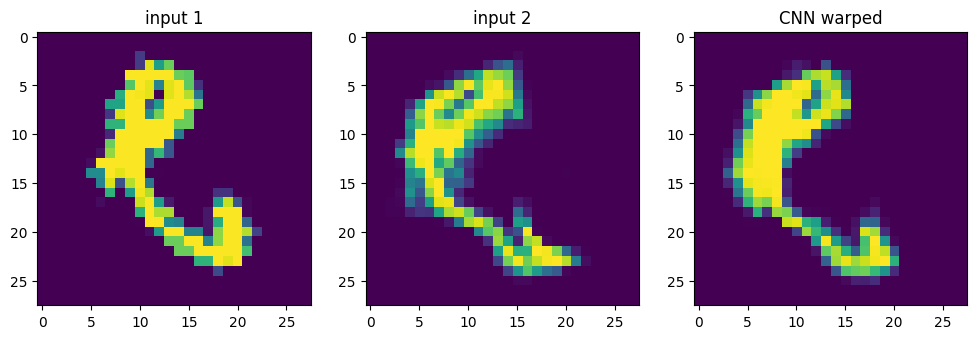

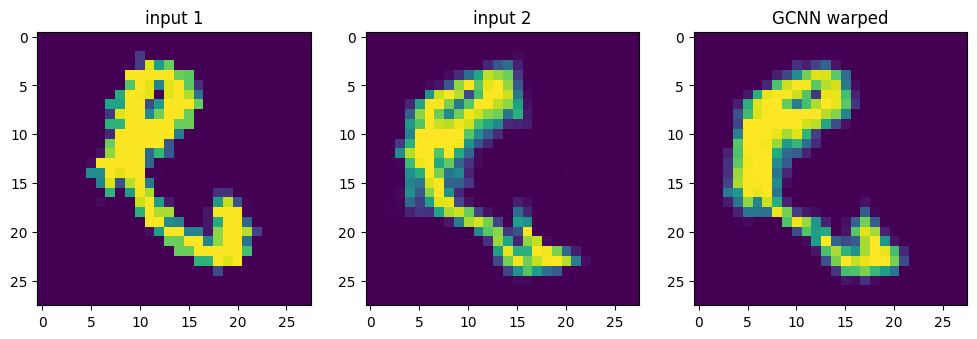

In [ ]:
num_ims = 10
input_s = inputs[:num_ims]
input_v = None
target = targets[:num_ims]


_, inv_out_cnn = inv_model_cnn_pl.model(input_s, input_v)
_, inv_out_gcnn = inv_model_gcnn_pl.model(input_s, input_v)

warped_images_cnn = apply_diffeomorphic_warp(input_s[:,:1,:,:], inv_out_cnn[:,0,...]).detach()
warped_images_gcnn = apply_diffeomorphic_warp(input_s[:,:1,:,:], inv_out_gcnn[:,0,...]).detach()

for imnr in range(num_ims):
    # Show result (CNN)
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    plt.imshow(input_s[imnr,0].squeeze().numpy())
    plt.title('input 1')
    plt.subplot(132)
    plt.imshow(input_s[imnr,1].squeeze().clamp(0,1).detach().numpy())
    plt.title('input 2')
    plt.subplot(133)
    plt.imshow(warped_images_cnn[imnr].squeeze().numpy())
    plt.title('CNN warped')
    plt.show()
    # Show result (GCNN)
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    plt.imshow(input_s[imnr,0].squeeze().numpy())
    plt.title('input 1')
    plt.subplot(132)
    plt.imshow(input_s[imnr,1].squeeze().clamp(0,1).detach().numpy())
    plt.title('input 2')
    plt.subplot(133)
    plt.imshow(warped_images_gcnn[imnr].squeeze().numpy())
    plt.title('GCNN warped')
    plt.show()

# This automatically quits the session

In [ ]:
from google.colab import runtime
runtime.unassign()